In [2]:

# %matplotlib notebook

import numpy as np
from scipy import ndimage
import scipy
import matplotlib.pyplot as plt
import torch
import skimage
import cv2

from multiPoseExtraction import MultiPoseExtraction
from PoseExtraction import PoseNormalization
from deepHOG import DeepHOG
from deepHogNormalization import DeepHogNormalization
import utils
import datasets as ds
from torch.autograd import Variable
from torchvision import datasets, transforms

import time
import glob

class Noise(torch.nn.Module):
    def __init__(self, scale=0.01):
        super(Noise, self).__init__()
        self.scale = scale

    def forward(self, x):
        device = x.device
        noise = (torch.randn_like(x)*self.scale).to(device)
        return x + noise
    
    
class Abs(torch.nn.Module):
    def __init__(self):
        super(Abs, self).__init__()

    def forward(self, x):
        return torch.abs(x)
    
class MaxNorm(torch.nn.Module):
    def __init__(self):
        super(MaxNorm, self).__init__()

    def forward(self, x):
        batch_size, _, _, _ = x.shape
        max_values = x.view(batch_size, -1).max(dim=1)[0]
        return x / max_values.unsqueeze(1).unsqueeze(2).unsqueeze(3)
    

def plot_arrow_img(ax, means, orientations, img_shape, arrow_scale=2, color=(1, 0, 0), alpha=0.8):
    mean_x = means[0].cpu().data.numpy()
    mean_y = means[1].cpu().data.numpy()

    rot = orientations.cpu().data.numpy()
    arrow_start = (mean_x, img_shape[1] - mean_y)
    arrow_end = (rot[0]*arrow_scale, -1*rot[1]*arrow_scale)

    #         ax[index % row_length].arrow(arrow_start[0], arrow_start[1], arrow_end[0], arrow_end[1], 
    #                     head_width=0.5, head_length=1, fc='red', ec='r', linewidth=4, alpha=1)

    ax.arrow(arrow_start[0], arrow_start[1], arrow_end[0], arrow_end[1], 
                head_width=np.sqrt(arrow_scale/4), head_length=np.sqrt(arrow_scale/4), fc='red', ec=color, linewidth=4, alpha=alpha)


def green_red_color_scale(value):
    color = (1 - value, value, 0)
    return color

im = np.zeros((256, 256))
im[64:-84, 64:-64] = 1

im = ndimage.rotate(im, 67, mode='constant')
im = ndimage.gaussian_filter(im, 8)

sx = ndimage.sobel(im, axis=0, mode='constant')
sy = ndimage.sobel(im, axis=1, mode='constant')
sob = np.hypot(sx, sy)

plt.figure(figsize=(16, 5))
plt.subplot(141)
plt.imshow(im, cmap=plt.cm.gray)
plt.axis('off')
plt.title('square', fontsize=20)
plt.subplot(142)
plt.imshow(sx)
plt.axis('off')
plt.title('Sobel (x direction)', fontsize=20)
plt.subplot(143)
plt.imshow(sob)
plt.axis('off')
plt.title('Sobel filter', fontsize=20)

im += 0.07*np.random.random(im.shape)

sx = ndimage.sobel(im, axis=0, mode='constant')
sy = ndimage.sobel(im, axis=1, mode='constant')
sob = np.hypot(sx, sy)

plt.subplot(144)
plt.imshow(sob)
plt.axis('off')
plt.title('Sobel for noisy image', fontsize=20)



plt.subplots_adjust(wspace=0.02, hspace=0.02, top=1, bottom=0, left=0, right=0.9)

plt.show()

# train, test, details = ds.smallNORBsingle()
# details = (64, 1, 28, 28)
# train = torch.utils.data.DataLoader(
#     datasets.MNIST('./data', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor()
#                    ])),
#     batch_size=64, shuffle=True)
# test = torch.utils.data.DataLoader(
#     datasets.MNIST('./data', train=False, transform=transforms.Compose([
#                        transforms.ToTensor()
#                    ])),
#     batch_size=64, shuffle=True)

In [5]:
img_files = glob.glob('/home/rees/Downloads/300w/01_Indoor/*.png')
img_files = sorted(img_files)
print(len(img_files))
imgs = []
labels = []

def read_facial_points(file_name):
    with open(file_name) as f:
        info = f.readlines()
    
    coords = []
    for line in info[3:-1]:
        coords.append(np.asarray(line.replace('\n', '').split(' ')).astype(float))
    
    return np.asarray(coords)

def get_bounding_box(iterable):
    min_x, min_y = np.min(iterable, axis=0)
    max_x, max_y = np.max(iterable, axis=0)
    
    return np.array([min_x, min_y, max_x, max_y])

plot = False
for i in range(300):
    new_img_size = (100, 100)
    points_path = img_files[i].replace('.png', '.pts')
    coords = read_facial_points(points_path)
    facial_subset = [0, 4, 8, 12, 16, # Jaw
#                      17, 21, # Left Eyebrow
#                      22, 26, # Right Eyebrow
                     27, 30, # Nose
                     36, 39, # Left Eye
                     42, 45, # Right Eye
                     48, 54 # Mouth
                    ]
    coords = coords[facial_subset]
    img = cv2.imread(img_files[i])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    height, width, channel = img.shape
    box_shift = np.array([-0.05*width, -0.1*height, 0.05*width, 0.1*height])
    box_shift = box_shift.astype(int)
    
    box = get_bounding_box(coords)
    box = box.astype(int)
    box = box + box_shift
    box = np.array([max(0, box[0]),
                    max(0, box[1]),
                    min(width, box[2]),
                    min(height, box[3]),
                   ])
    
#     box = np.clip(0,2000, box)
    coords -= box[:2]
    crop = img[box[1]:box[3], box[0]:box[2]]
    crop_height, crop_width, _ = crop.shape

    resize_ratio = (new_img_size[0] / crop_width, new_img_size[1] / crop_height)
    coord_resize = np.zeros_like(coords)
    coord_resize[:, 0] = coords[:, 0] * resize_ratio[0]
    coord_resize[:, 1] = coords[:, 1] * resize_ratio[1]

    img_resize = cv2.resize(crop, new_img_size)
    img_resize = img_resize / img_resize.max()
    imgs.append(torch.Tensor(img_resize))
    labels.append(torch.Tensor(coord_resize))
    
    if plot:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(crop)
        for point in coords:
            ax[0].plot(point[0], point[1], 'r*')

        ax[1].imshow(img_resize)
        for point in coord_resize:
            ax[1].plot(point[0], point[1], 'r*')
    
    
tensor_imgs = torch.stack(imgs, dim=0).permute(0, 3, 1, 2)
tensor_labels = torch.stack(labels, dim=0).view(-1, 26)

details = tensor_imgs.shape
print(tensor_imgs.shape)
print(tensor_labels.shape)

300
torch.Size([300, 3, 100, 100])
torch.Size([300, 26])


In [3]:
import scipy.io as sio

def get_bounding_box(iterable):
    min_x, min_y = np.min(iterable, axis=0)
    max_x, max_y = np.max(iterable, axis=0)
    
    return np.array([min_x, min_y, max_x, max_y])


img_files = glob.glob('/home/rees/Downloads/lsp_dataset/images/*.jpg')
img_files = sorted(img_files)
print(len(img_files))
imgs = []
labels = []
joint_data = sio.loadmat('/home/rees/Downloads/lsp_dataset/joints.mat')
index = 2
current_joint = np.vstack([joint_data['joints'][0, :, index], joint_data['joints'][1, :, index]]).T
print(current_joint.shape)
img = cv2.imread(img_files[index])
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# fig, ax = plt.subplots(figsize=(20, 10))
# ax.imshow(img)
# for (x, y) in current_joint:
#     ax.plot(x, y, 'r*')
plot = False


for index in range(2000):
    new_img_size = (200, 200)
    coords = np.vstack([joint_data['joints'][0, :, index], joint_data['joints'][1, :, index]]).T

    img = cv2.imread(img_files[index])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    height, width, channel = img.shape
    box_shift = np.array([-0.05*width, -0.1*height, 0.05*width, 0.1*height])
    box_shift = box_shift.astype(int)
    
    box = get_bounding_box(coords)
    box = box.astype(int)
    box = box + box_shift
    box = np.array([max(0, box[0]),
                    max(0, box[1]),
                    min(width, box[2]),
                    min(height, box[3]),
                   ])
    
#     box = np.clip(0,2000, box)
    coords -= box[:2]
    crop = img[box[1]:box[3], box[0]:box[2]]
    crop_height, crop_width, _ = crop.shape

    resize_ratio = (new_img_size[0] / crop_width, new_img_size[1] / crop_height)
    coord_resize = np.zeros_like(coords)
    coord_resize[:, 0] = coords[:, 0] * resize_ratio[0]
    coord_resize[:, 1] = coords[:, 1] * resize_ratio[1]

    img_resize = cv2.resize(crop, new_img_size)
    img_resize = img_resize / img_resize.max()
    imgs.append(torch.Tensor(img_resize))
    labels.append(torch.Tensor(coord_resize))
    
    if plot:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(crop)
        for point in coords:
            ax[0].plot(point[0], point[1], 'r*')

        ax[1].imshow(img_resize)
        for point in coord_resize:
            ax[1].plot(point[0], point[1], 'r*')
    
    
tensor_imgs = torch.stack(imgs, dim=0).permute(0, 3, 1, 2)
tensor_labels = torch.stack(labels, dim=0).view(-1, 28)

train_imgs = tensor_imgs[:1700]
train_labels = tensor_labels[:1700]
test_imgs = tensor_imgs[1700:]
test_labels = tensor_labels[1700:]


train = torch.utils.data.TensorDataset(train_imgs, train_labels)
train = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False)

test = torch.utils.data.TensorDataset(test_imgs, test_labels)
test = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)


details = tensor_imgs.shape
print(tensor_imgs.shape)
print(tensor_labels.shape)

2000
(14, 2)
torch.Size([2000, 3, 200, 200])
torch.Size([2000, 28])


torch.Size([1, 3, 7, 7]) torch.Size([1, 3, 7, 7])
HOG COMPUTATION TIME: 0.0005977153778076172
EXAMPLE BATCH NUM 9
torch.Size([32, 144, 4])
torch.Size([32, 144, 25, 25])
IMG SHAPE torch.Size([32, 3, 200, 200])
THeta torch.Size([32, 2, 3])
IMG SHAPE torch.Size([32, 3, 200, 200])
THeta torch.Size([32, 2, 3])
IMG SHAPE torch.Size([32, 3, 200, 200])
THeta torch.Size([32, 2, 3])
IMG SHAPE torch.Size([32, 3, 200, 200])
THeta torch.Size([32, 2, 3])
IMG SHAPE torch.Size([32, 3, 200, 200])
THeta torch.Size([32, 2, 3])
IMG SHAPE torch.Size([32, 3, 200, 200])
THeta torch.Size([32, 2, 3])
IMG SHAPE torch.Size([32, 3, 200, 200])
THeta torch.Size([32, 2, 3])
IMG SHAPE torch.Size([32, 3, 200, 200])
THeta torch.Size([32, 2, 3])
IMG SHAPE torch.Size([32, 3, 200, 200])
THeta torch.Size([32, 2, 3])
IMG SHAPE torch.Size([32, 3, 200, 200])
THeta torch.Size([32, 2, 3])


' tensor(1.00000e-03 *\n       [[ 0.0147,  1.4941,  6.6934,  0.0335,  0.0147,  3.6438,  3.0195,\n          0.8639,  0.0147,  0.5695,  3.9100,  0.0429,  0.0147,  0.0147,\n          0.0147,  0.0147]])'

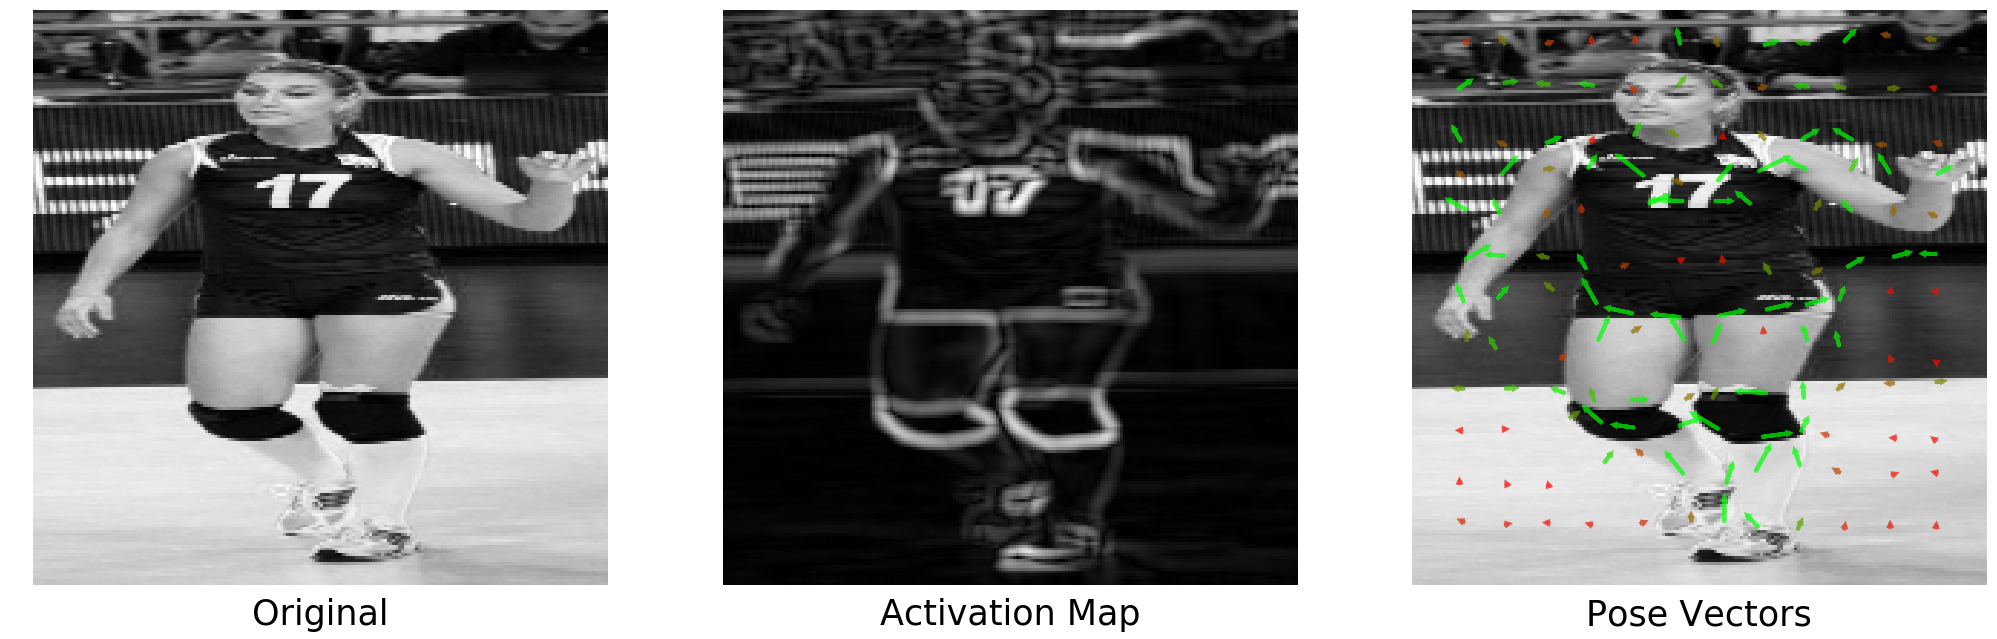

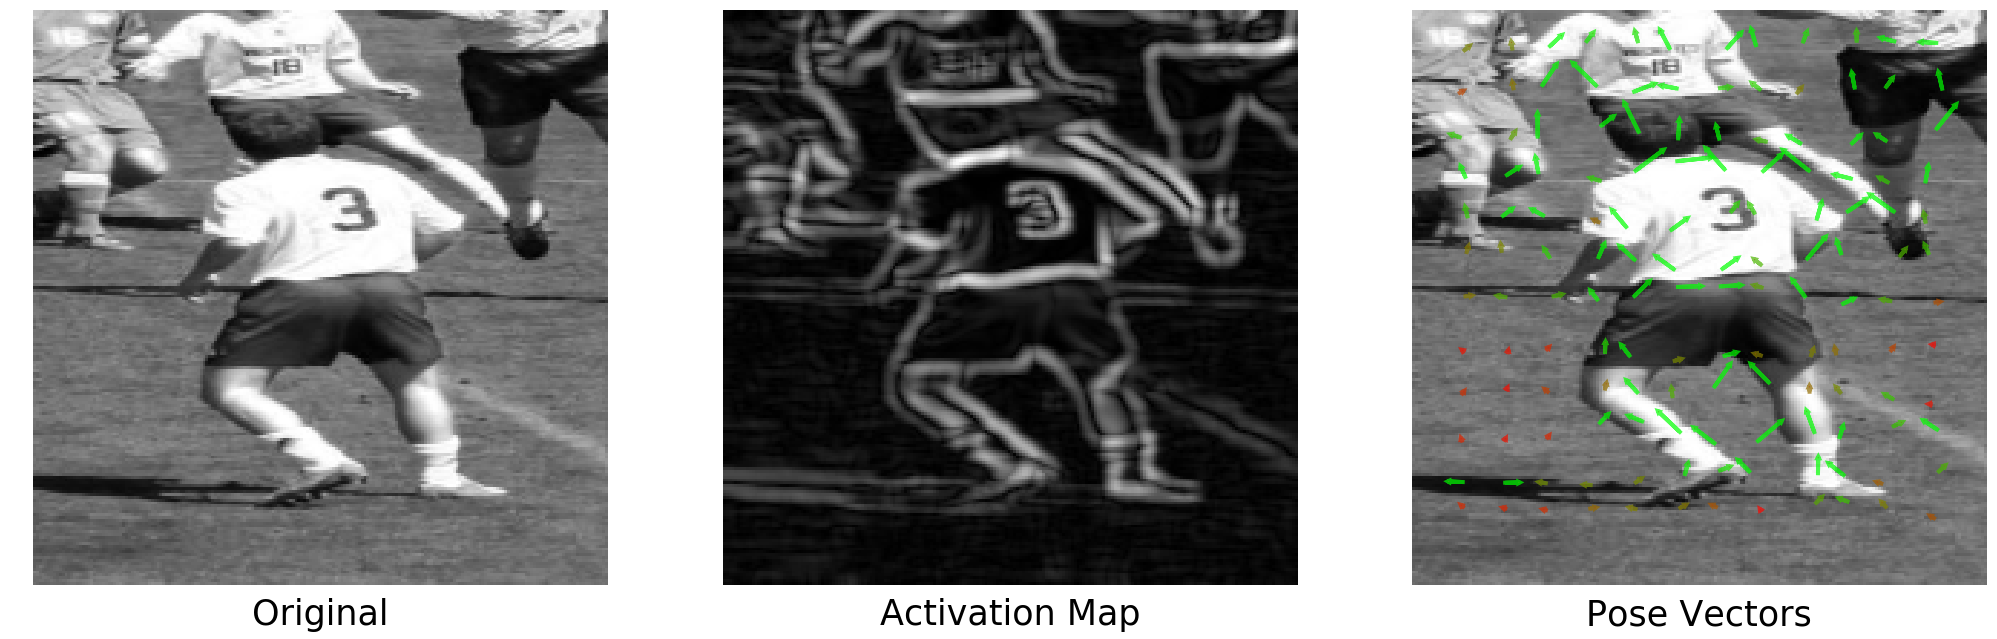

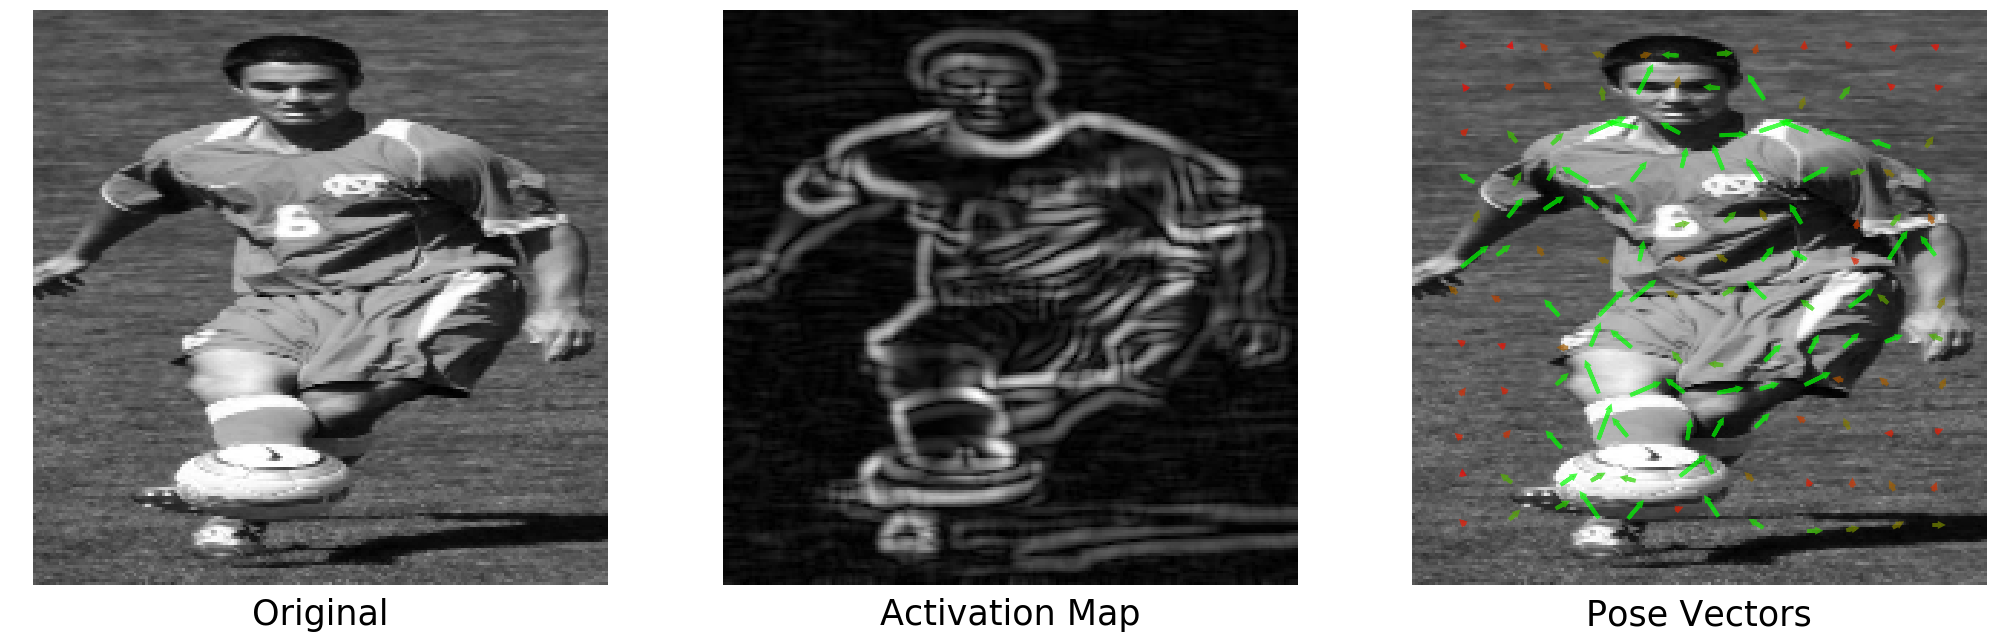

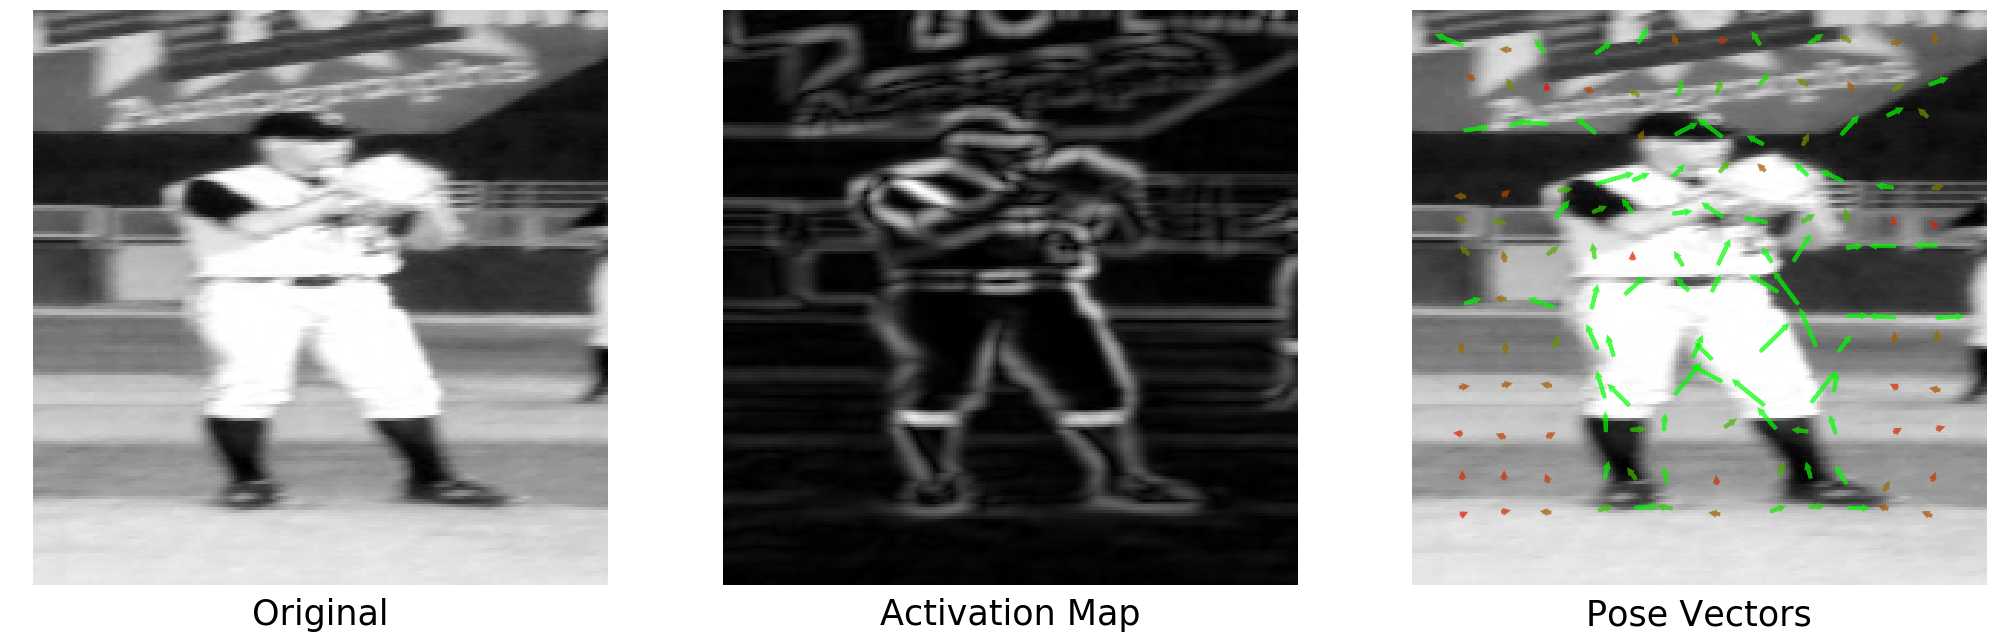

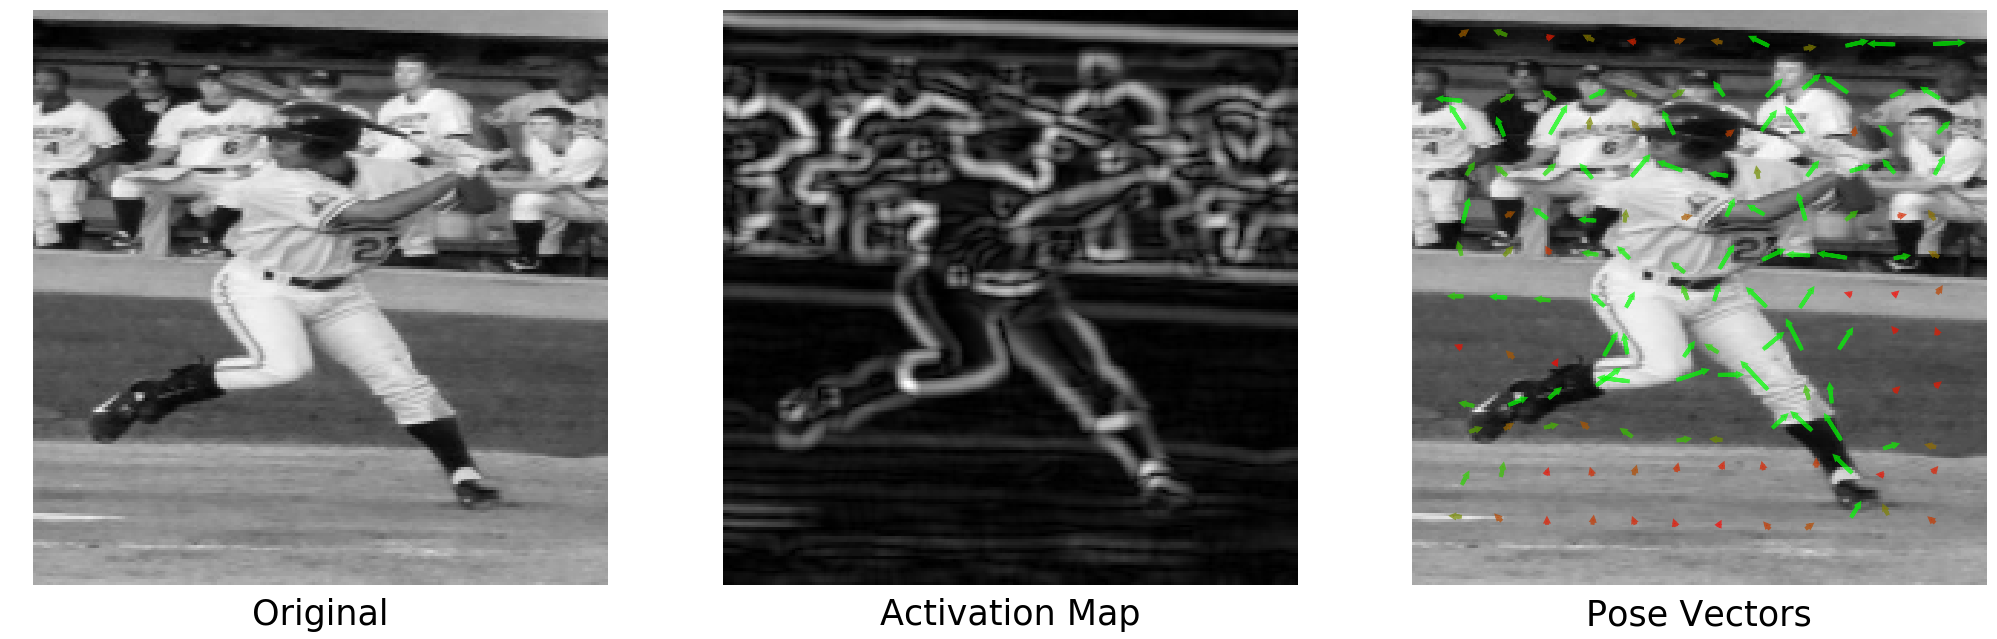

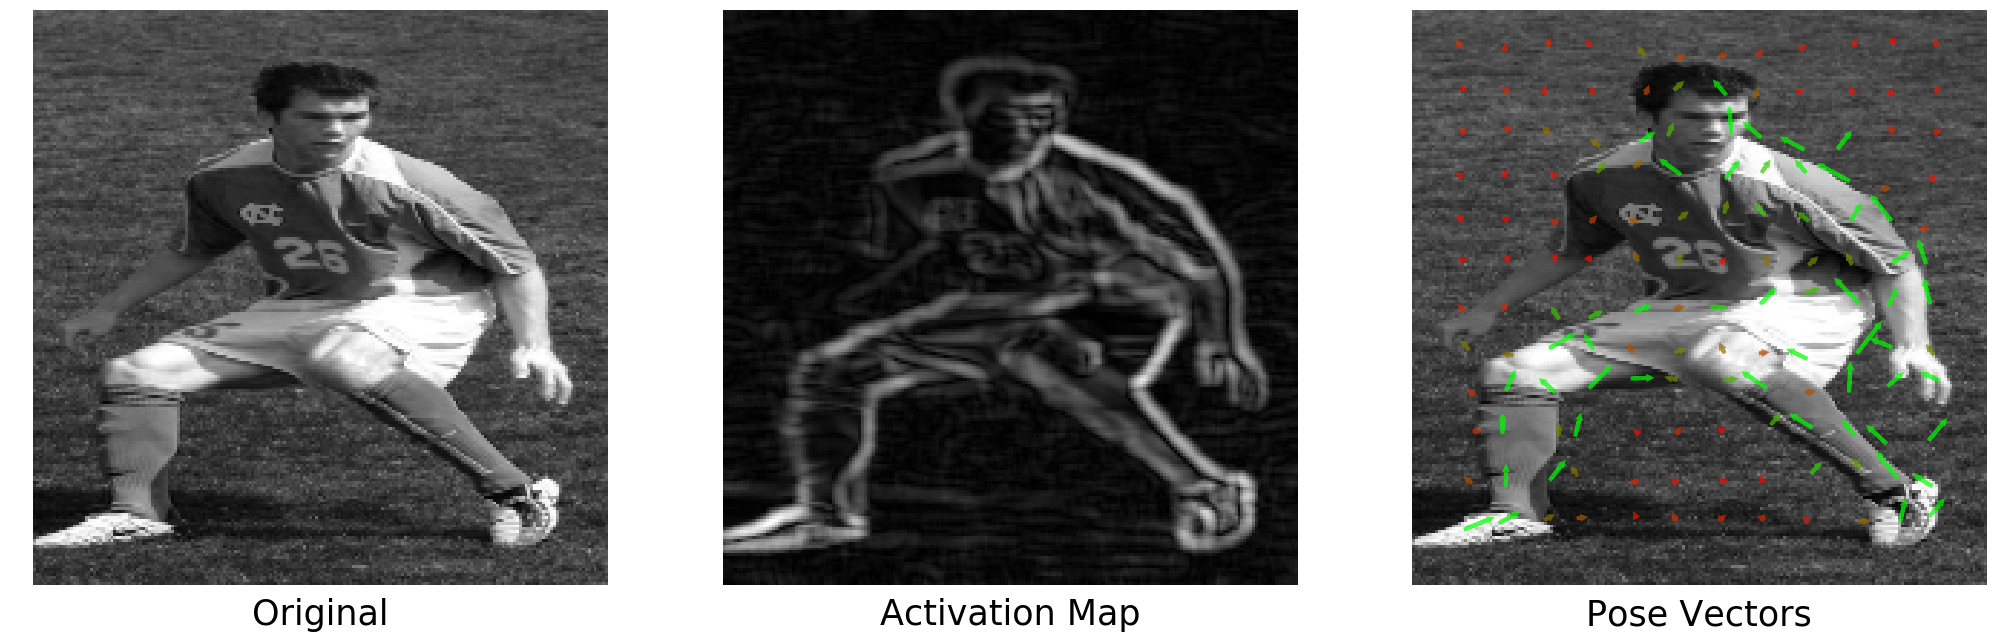

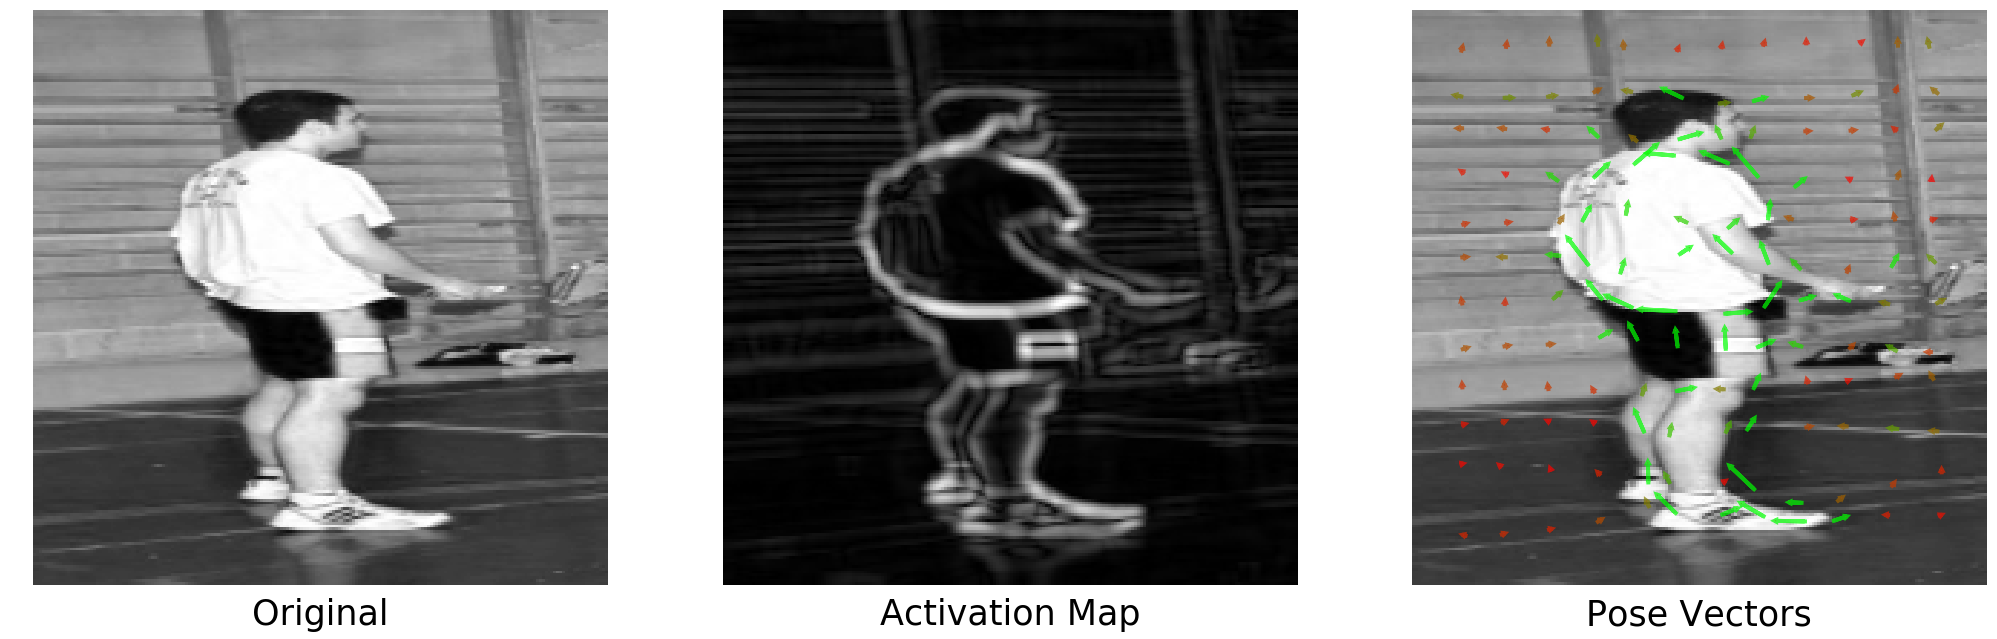

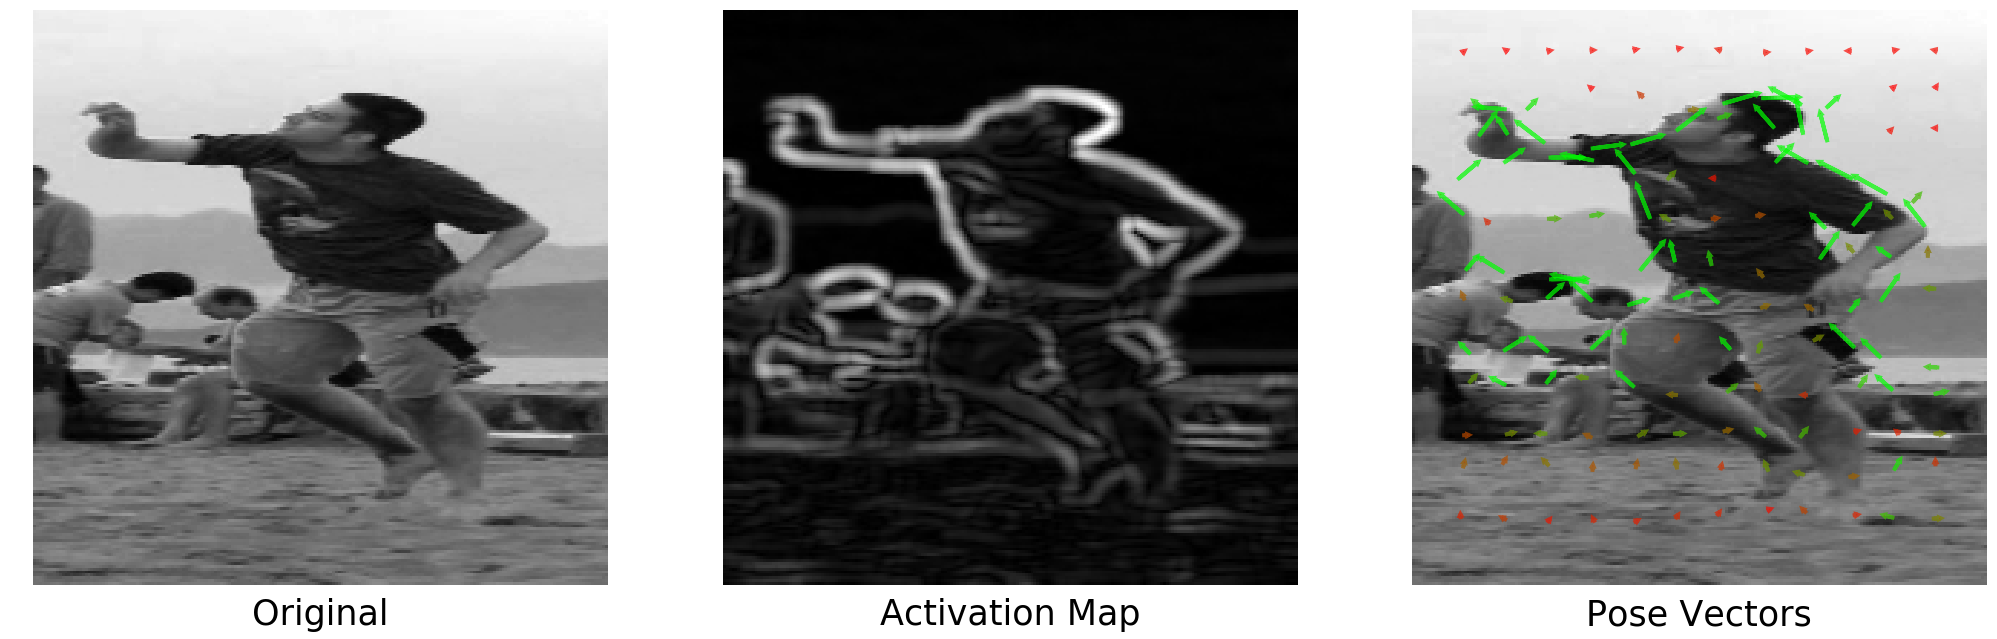

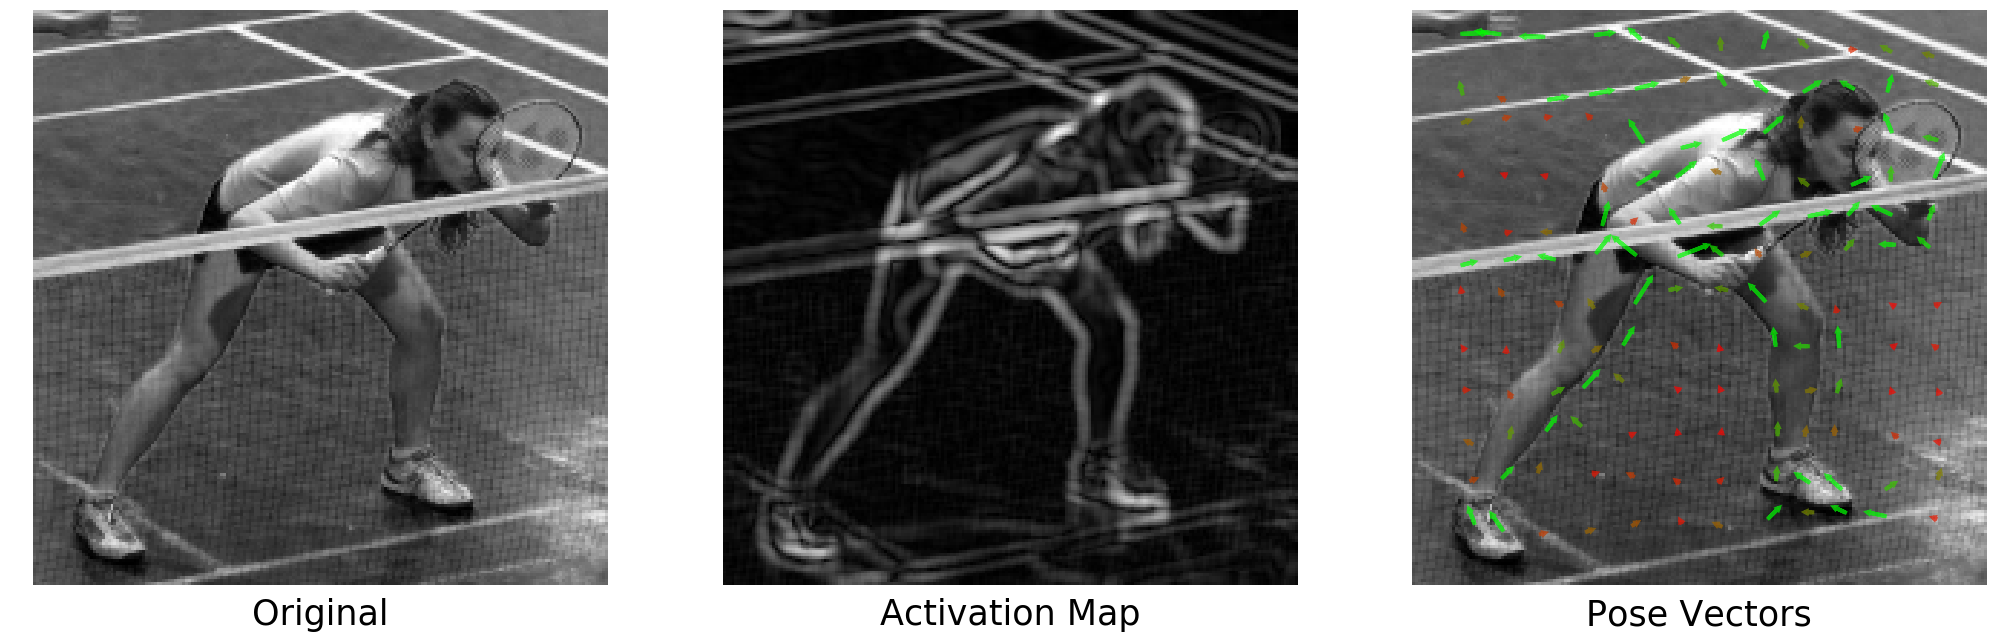

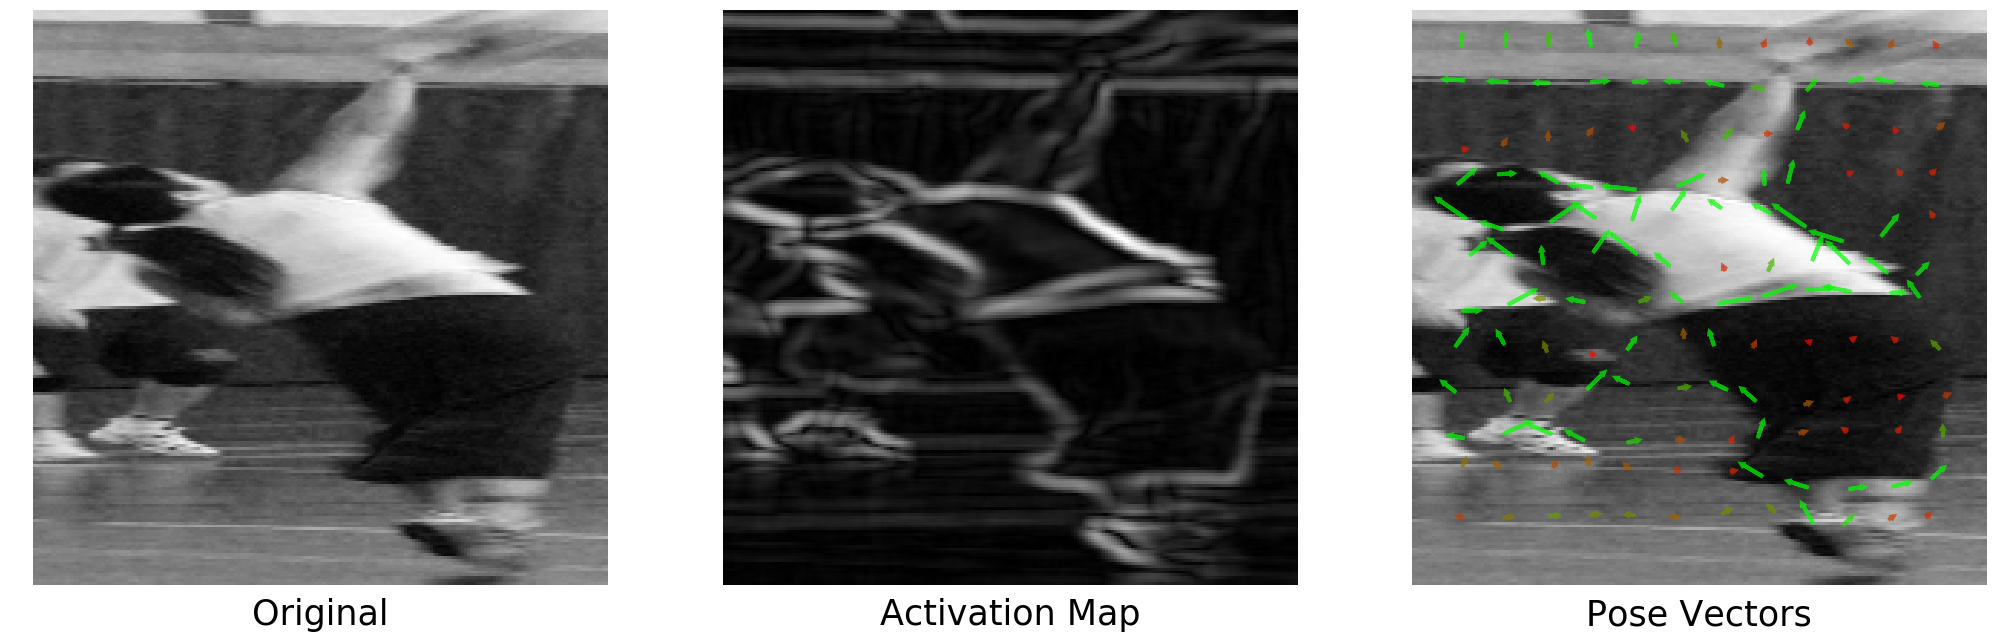

In [53]:
def create_orientation_vectors(x, window_size):
    unfold = torch.nn.Unfold(kernel_size=window_size, stride=window_size)
    blocks = unfold(x)
    batch_size, _, channel_num = blocks.shape

    multi_pose = MultiPoseExtraction(channel_num)
    mean = x.mean()
    blocks = blocks.permute([0, 2, 1]).view(batch_size, channel_num, window_size, window_size)
    block_means = blocks.view(batch_size, channel_num, window_size * window_size).mean(dim=2)
    print(block_means)
#     print(block_means.shape)
#     print(block_means.shape)
    mu_W, U, mu_avg, T_orig, theta, (L1, L2) = multi_pose(blocks)
    confidence = ((L1 / L2).unsqueeze(2) - 1) * (block_means.unsqueeze(2) / mean)
    output = torch.cat([mu_W[:, :, :, 0], U[:, :, 0, :] * confidence], dim=2)
#     output = U[:, :, 0, :] * confidence
    return output, blocks

def apply_theta_transform(img_tensor, theta, padding=25):
    print("IMG SHAPE", img_tensor.shape)
    print("THeta", theta.shape)
#     theta[:, :, 2] -= torch.Tensor([padding / img_tensor.shape[2], -1*(padding/ img_tensor.shape[3])]).view(1, 2)
    pad = torch.nn.ReflectionPad2d([padding, padding, padding, padding])
    padded_img = pad(img_tensor)
    grid = torch.nn.functional.affine_grid(theta, padded_img.size())
    transformed_img_tensor = torch.nn.functional.grid_sample(padded_img, grid)
    transformed_img_tensor = transformed_img_tensor[:, :, padding:-1*padding, padding:-1*padding]
    return transformed_img_tensor

def congregate_pose(orientations):
    M = torch.bmm(orientations.permute(0, 2, 1), orientations)
    T = M[:, 0, 0] + M[:, 1, 1]
    D = M[:, 0, 0] * M[:, 1, 1] - M[:, 0, 1] * M[:, 1, 0]
    L1 = (T + torch.sqrt(torch.nn.functional.relu((T**2) - 4*D))) / 2
    v1 = torch.stack([L1 - M[:, 1, 1], M[:, 1, 0]]).permute(1, 0)
    v1 = torch.nn.functional.normalize(v1, dim=1)
    return v1


X_train = []
y_train = []

X_test = []
y_test = []


channel_num = details[1]


blur = torch.Tensor([[0.25, 0.5, 0.25], [0.5, 1, 0.5], [0.25, 0.5, 0.25]])
kernel_size = 7
grad_x = torch.range(-1*(kernel_size // 2), kernel_size // 2).repeat(kernel_size, 1)
grad_y = grad_x.t()

grad_x = grad_x.repeat(1, channel_num, 1, 1)
grad_y = grad_y.repeat(1, channel_num, 1, 1)

print(grad_x.shape, grad_y.shape)

conv = torch.nn.Conv2d(channel_num, 2, kernel_size=kernel_size, bias=False)
conv.weight.data = torch.cat([grad_x, grad_y], dim=0)

conv_add = torch.nn.Conv2d(2, 1, kernel_size=1, bias=False)
conv_add.weight.data = torch.ones(1, 2, 1, 1)

conv_add2 = torch.nn.Conv2d(3, 1, kernel_size=1, bias=False)
conv_add2.weight.data = (1/3) * torch.ones(1, 3, 1, 1)


pad = torch.nn.ReplicationPad2d([kernel_size // 2, kernel_size // 2, 
                                 kernel_size // 2, kernel_size // 2])
noise = Noise(0.0001)
max_pool = torch.nn.MaxPool2d(2)

edge_detector = torch.nn.Sequential(pad, conv, Abs(), conv_add, MaxNorm(), noise)
# edge_detector = torch.nn.Sequential(Abs(), conv_add2, MaxNorm(), noise)
preprocess = torch.nn.Sequential(Abs(), MaxNorm(), noise)

abs_val = Abs()
window_size = 25
stride = 15
count = 3
# print(window_size, (details[3] // window_size)**2)
t1 = time.time()
deep_hog = DeepHOG(window_size=window_size, stride=stride)
deep_hog_normalizer = DeepHogNormalization(channel_num=1, window_size=window_size, stride=stride)

t2 = time.time()
print("HOG COMPUTATION TIME: {}".format(t2 - t1))
noise = Noise(0.0001)

# example_batch = np.random.randint(50)
example_batch = 9
print("EXAMPLE BATCH NUM", example_batch)
for i, (img_orig, label) in enumerate(train):
    if i == example_batch:
        break
    
    

# output, blocks, mu_global, U_global, theta = deep_hog(img_orig[:, 0:1])
# feature_maps = conv_add2(abs_val((features(img_orig))))

output, blocks, mu_global, U_global, theta = deep_hog(edge_detector(img_orig))
output = output.data
blocks = blocks.data
mu_global = mu_global.data
eig_pose_vects = congregate_pose(output[:, :, 2:])

print(output.shape)
print(blocks.shape)



for index_num in range(10):    
    index_num += 8
    orientations = torch.Tensor([0, 0])
    
    sx = ndimage.sobel(im, axis=0, mode='constant')
    sy = ndimage.sobel(im, axis=1, mode='constant')
    sob = np.hypot(sx, sy)
    sob = sob[1:-1, 1:-1]
    sob = sob ** 1
    sob = sob / sob.sum()
    
    _, channel_num, _, _ = blocks.shape

    block_shape = blocks[index_num, 0].shape

    fig, ax = plt.subplots(1, 3, figsize=(35, 15))
#     ax[0].imshow(utils.tensor_to_numpy_img(sob_tensor[index_num:index_num+1]))
    ax[0].imshow(img_orig[index_num].permute(1, 2, 0)[:, :, 0], cmap='gray')
    ax[0].axis('off')
    ax[0].set_title("Original", y=-0.08, fontsize=35)
    
    ax[1].imshow(edge_detector(img_orig).data[index_num].permute(1, 2, 0)[:, :, 0], cmap='gray')
    ax[1].axis('off')
    ax[1].set_title("Activation Map", y=-0.08, fontsize=35)
    
    row_num, col_num = int(np.sqrt(blocks.shape[1])), int(np.sqrt(blocks.shape[1]))
#     fig2, ax2 = plt.subplots(row_num, col_num, figsize=(15, 15))
#     ax[2].set_xlim(-2, 2)
#     ax[2].set_ylim(0, 5)
    
    ax[2].imshow(img_orig[index_num].permute(1, 2, 0)[:, :, 0], cmap='gray')
    ax[2].axis('off')
    ax[2].set_title("Pose Vectors", y=-0.08, fontsize=35)
    
    
#     current_ax = ax[2]
    for x in range(row_num):
        for y in range(col_num):
#             if row_num == 1 and col_num == 1:
#                 current_ax = ax2
#             elif row_num == 1:
#                 current_ax = ax2[y]
#             elif col_num == 1:
#                 current_ax = ax2[x]
#             else:
#                 current_ax = ax2[x, y]
            mean2 = output[index_num, x*col_num + y, :2]
#             print(mean2.shape)
            orientation2 = output[index_num, x*col_num + y, 2:]
            orientations += orientation2
            current_ax.axis('off')
            current_ax.set_title("{} - {}".format(int(x*stride), int(y*stride)))
            arrow_scale = 1.2

#             current_ax.imshow(blocks[index_num, x*col_num + y], cmap='gray', vmin=0, vmax=1)
#             current_ax.imshow(torch.zeros_like(blocks[index_num, x*col_num + y]), vmin=0, vmax=1)

            norm_value = torch.norm(orientation2)
            norm_value = min(norm_value.item() / 3, 1)
            color_value = green_red_color_scale(norm_value)
#             plot_arrow_img(current_ax, mean2, orientation2,  np.array([24, 24]),
#                            arrow_scale=arrow_scale, alpha=0.7, color=color_value)
        
            plot_arrow_img(ax[2], mean2 + torch.Tensor([(y*stride) + 5, (200 - x*stride) - 25]), orientation2,  np.array([199, 199]),
               arrow_scale=arrow_scale, alpha=0.7, color=color_value)
            
#             plot_arrow_img(ax[2], torch.Tensor([0, 0]), orientation2,  (2, 2)
#                , arrow_scale=arrow_scale, alpha=0.7, color=color_value)
    
    orientations = torch.nn.functional.normalize(orientations, dim=0)
    
#     U, S, eig_mean = torch.svd(output[index_num, :, 2:])  
    
#     plot_arrow_img(ax[0], mu_global[index_num, 0, :, 0], U_global[index_num, 0, :], (details[2], details[3])
#            , arrow_scale=20, alpha=0.9, color='b')
    
#     plot_arrow_img(ax[2], torch.Tensor([0, 0]), U_global[index_num, 0, :],  (2, 2),
#                    arrow_scale=arrow_scale, alpha=1, color='b')
    
    theta = deep_hog_normalizer(edge_detector(img_orig)).data
    new_img_tensor = apply_theta_transform(img_orig, theta)
    
#     ax[1].imshow(new_img_tensor[index_num].permute(1, 2, 0)[:, :, 0])
""" tensor(1.00000e-03 *
       [[ 0.0147,  1.4941,  6.6934,  0.0335,  0.0147,  3.6438,  3.0195,
          0.8639,  0.0147,  0.5695,  3.9100,  0.0429,  0.0147,  0.0147,
          0.0147,  0.0147]])"""

In [ ]:
index = 1
edge_imgs = edge_detector(img_orig)
compressed_imgs = torch.nn.functional.max_pool2d(edge_imgs, kernel_size=20)
T = output[:, :, 2:]
T_norm = torch.norm(T, dim=2)
print(T_norm.shape)
width, height = int(np.sqrt(output.shape[1])), int(np.sqrt(output.shape[1]))
print("Original Shape", width, height)
T_comp, indecies = torch.nn.functional.max_pool2d(T_norm.view(-1, width, height), kernel_size=4, return_indices=True)
flattened_indicies = indecies.view(32, -1)
width_comp, height_comp = int(np.sqrt(flattened_indicies.shape[1])), int(np.sqrt(flattened_indicies.shape[1]))
print(flattened_indicies.shape)
# T_new = T[torch.Tensor([[0, 1], [5, 6]]).long()]
T_test = torch.index_select(T_norm, 1, flattened_indicies[index])
output_compressed = torch.index_select(output, 1, flattened_indicies[index])
print(output_compressed.shape)
print("Compressed Shape", width_comp, height_comp)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(T_norm[index].view(width, height))
ax[1].imshow(T_test[index].view(width_comp, height_comp))

fig2, ax2 = plt.subplots(1, 2)
ax2[0].imshow(edge_imgs[index, 0].data)
ax2[1].imshow(compressed_imgs[index, 0].data)

row_num, col_num = (width_comp, height_comp)
fig2, ax2 = plt.subplots(row_num, col_num, figsize=(15, 15))

for x in range(row_num):
    for y in range(col_num):
        if row_num == 1 and col_num == 1:
            current_ax = ax2
        elif row_num == 1:
            current_ax = ax2[y]
        elif col_num == 1:
            current_ax = ax2[x]
        else:
            current_ax = ax2[x, y]

        mean2 = output_compressed[index, x*col_num + y, :2]

        orientation2 = output_compressed[index, x*col_num + y, 2:]
        current_ax.axis('off')
        arrow_scale = 1.2

#             current_ax.imshow(blocks[index_num, x*col_num + y], vmin=0, vmax=1)
        current_ax.imshow(torch.zeros_like(blocks[index_num, x*col_num + y]), vmin=0, vmax=1)

        norm_value = torch.norm(orientation2)
        norm_value = min(norm_value.item() / 3, 1)
        color_value = green_red_color_scale(norm_value)
        plot_arrow_img(current_ax, mean2, orientation2,  (block_shape[0] - 1, block_shape[1] - 1)
                       , arrow_scale=arrow_scale, alpha=0.7, color=color_value)

torch.Size([32, 1296])
Original Shape 36 36
torch.Size([32, 81])
torch.Size([32, 81, 4])
Compressed Shape 9 9


In [86]:
print(output.shape)
output.permute(0, 2, 1).view(32, 4, 37, 37)[:, 2:, :3, :3].contiguous().view(32, 2, 9).shape

torch.Size([32, 1369, 4])


torch.Size([32, 2, 9])

In [61]:
fold = torch.nn.Fold(output_size=(4, 4), kernel_size=(3, 3))
input = torch.randn(1, 3 * 2 * 2, 12)
output = fold(input)
output.size()

torch.Size([1, 1, 4, 4])

In [17]:
kernel_size = 5
x_filter = torch.range(-1*(kernel_size // 2), kernel_size // 2).repeat(kernel_size, 1)
y_filter = x_filter.t()
print(x_filter)
print(y_filter)

tensor([[-2., -1.,  0.,  1.,  2.],
        [-2., -1.,  0.,  1.,  2.],
        [-2., -1.,  0.,  1.,  2.],
        [-2., -1.,  0.,  1.,  2.],
        [-2., -1.,  0.,  1.,  2.]])
tensor([[-2., -2., -2., -2., -2.],
        [-1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.],
        [ 2.,  2.,  2.,  2.,  2.]])


In [ ]:
import matplotlib.pyplot as plt

data = [[0, 0.25], [0.1, 0.01]]

fig, ax = plt.subplots()
im = ax.imshow(data, cmap=plt.get_cmap('hot'), interpolation='nearest',
               vmin=0, vmax=1)
fig.colorbar(im)
plt.show()

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import torch.nn as nn
import torch.nn.functional as F

img_shape = (28, 28)

class PICNN(torch.nn.Module):
    def __init__(self):
        super(PICNN, self).__init__()
        self.features1 = nn.Sequential(
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(3, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2), ######
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), ######
        )
        self.features2 = nn.Sequential(
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.regressor1 = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Linear(21*21*32, 5),
            nn.Dropout(p=0.25),
            nn.Linear(30, 15)
        )
        
        kernel_size = 5
        grad_x = torch.range(-1*(kernel_size // 2), kernel_size // 2).repeat(kernel_size, 1)
        grad_y = grad_x.t()
        grad_x = grad_x.repeat(1, 1, 1, 1)
        grad_y = grad_y.repeat(1, 1, 1, 1)
        
        conv = torch.nn.Conv2d(1, 2, kernel_size=kernel_size, bias=False)
        conv.weight.data = torch.cat([grad_x, grad_y], dim=0)

        conv_add = torch.nn.Conv2d(2, 1, kernel_size=1, bias=False)
        conv_add.weight.data = torch.ones(1, 2, 1, 1)

        pad = torch.nn.ReplicationPad2d([1, 1, 1, 1])
            
        self.edge_detector = torch.nn.Sequential(pad, conv, conv_add, Abs())
        
        conv_add2 = torch.nn.Conv2d(3, 1, kernel_size=1, bias=False)
        conv_add2.weight.data = torch.ones(1, 1, 1, 1)
        noise = Noise(0.00001)  
        deep_hog = DeepHOG(window_size=20, stride=10)
        max_norm = MaxNorm()
        self.base = nn.Sequential(conv_add2, noise, max_norm, deep_hog)
        
        
    def correct_pose(self, x):
        x_s = self.edge_detector(x)
        _, _, _, _, theta = self.base(x_s)
        grid = torch.nn.functional.affine_grid(theta, x.size())
        transformed_img_tensor = torch.nn.functional.grid_sample(x, grid)
        return x
    
    def forward(self, x):
        x = self.correct_pose(x)
        x = self.features1(x)
        x = self.features2(x)

        x = x.view(x.size(0), -1)

        x = self.regressor1(x)
        return x        

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#         self.pose_norm = PoseNormalization(1, (img_shape[1], img_shape[0]))
        
        self.fc1 = torch.nn.Linear(361 * 2, 400)
        self.fc2 = torch.nn.Linear(400, 28)
        self.dropout = torch.nn.Dropout(0.2)
        self.deep_hog = DeepHOG(window_size=20, stride=10)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.elu = torch.nn.ELU()
        
        
        conv = torch.nn.Conv2d(3, 2, kernel_size=3, bias=False)
        
        kernel_size = 3
        grad_x = torch.range(-1*(kernel_size // 2), kernel_size // 2).repeat(kernel_size, 1)
        grad_y = grad_x.t()
        grad_x = grad_x.repeat(1, 3, 1, 1)
        grad_y = grad_y.repeat(1, 3, 1, 1)
        conv.weight.data = torch.cat([grad_x, grad_y], dim=0)

        conv_add = torch.nn.Conv2d(2, 1, kernel_size=1, bias=False)
        conv_add.weight.data = torch.ones(1, 2, 1, 1)
        
        conv_add2 = torch.nn.Conv2d(3, 1, kernel_size=1, bias=False)
        conv_add2.weight.data = torch.ones(1, 3, 1, 1)

        pad = torch.nn.ReplicationPad2d([1, 1, 1, 1])
        max_pool = torch.nn.MaxPool2d(2)
        
        self.noise = Noise(0.0000001)    
        
        conv1 = torch.nn.Conv2d(3, 3, kernel_size=3, bias=False)
        conv2 = torch.nn.Conv2d(3, 3, kernel_size=3, bias=False)
        conv3 = torch.nn.Conv2d(3, 1, kernel_size=3, bias=False)
#         self.features = torch.nn.Sequential(pad, conv1, self.elu, pad, conv2, 
#                                             self.elu, pad, conv3, Abs(), MaxNorm())
        
        self.edge_detector = torch.nn.Sequential(pad, conv, Abs(), conv_add, MaxNorm(), self.noise)
        
#         self.edge_detector = torch.nn.Sequential(pad, conv, conv_add, Abs(), MaxNorm())
#         self.edge_detector = torch.nn.Sequential(pad, conv, conv_add, Abs())
        
#         self.base = nn.Sequential(conv_add2, self.noise, MaxNorm(), self.deep_hog)
        self.base2 = nn.Sequential(self.edge_detector, self.noise, self.deep_hog)
        self.classifier = nn.Sequential(self.dropout, self.fc1, self.elu, self.dropout, self.fc2)
    
    def correct_pose(self, x):
        _, _, _, theta = self.base2(x)
        grid = torch.nn.functional.affine_grid(theta, x.size())
        transformed_img_tensor = torch.nn.functional.grid_sample(x, grid)
        return x
        
    
    def forward(self, x):
        x, blocks, mu_global, U_global, theta = self.base2(x)
        x = x[:, :, 2:]
        x = x.contiguous().view(-1, (361 * 2))
        
        x = self.classifier(x)
        return x

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
#         self.pose_norm = PoseNormalization(1, (img_shape[1], img_shape[0]))
        conv = torch.nn.Conv2d(3, 2, kernel_size=3, bias=False)
        conv.weight.data = torch.cat([grad_x, grad_y], dim=0)

        conv_add = torch.nn.Conv2d(2, 1, kernel_size=1, bias=False)
        conv_add.weight.data = torch.ones(1, 2, 1, 1)

        pad = torch.nn.ReplicationPad2d([1, 1, 1, 1])
        max_pool = torch.nn.MaxPool2d(2)
        
        self.noise = Noise(0.0000001)    
            
        self.edge_detector = torch.nn.Sequential(pad, conv, conv_add, Abs(), MaxNorm(), max_pool)
        
        self.fc1 = torch.nn.Linear(32 * 32, 30)
        self.fc2 = torch.nn.Linear(30, 15)
        self.dropout = torch.nn.Dropout(0.25)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.elu = torch.nn.ELU()
            
        self.deep_hog = DeepHOG(window_size=4)
        
        self.base = nn.Sequential(self.edge_detector)
        self.classifier = nn.Sequential(self.dropout, self.fc1, self.elu, self.fc2)
        
    def forward(self, x):
        x = self.base(x)
        x = x.view(-1, (32 * 32))
        x = self.classifier(x)
        return x
    
class CNNBasic(nn.Module):
    def __init__(self):
        super(CNNBasic, self).__init__()
        self.features1 = nn.Sequential(
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(3, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2), ######
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), ######
        )
        self.features2 = nn.Sequential(
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.regressor1 = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Linear(50*50*32, 30),
            nn.Dropout(p=0.25),
            nn.Linear(30, 28)
        )

    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)

        x = x.view(x.size(0), -1)

        x = self.regressor1(x)
        return x


# model = CNN(1, (28, 28))
model = Net()
model.to(device)
for (img, label) in train:
    break

loss_function = torch.nn.MSELoss()
# optimizer_function = torch.optim.Adam([{'params': model.edge_detector.parameters(), 'lr':0.02},
#                                        {'params': model.classifier.parameters(), 'lr': 0.005}]
                                      
#                                       , lr=0.003)

optimizer_function = torch.optim.Adam(model.parameters(), lr=0.001)

# output = model(img)

# loss = loss_function(output, label)
epoch_num = 100
batch_num = 50

model, model_loss, model_acc, model_loss_validation = utils.train_net(model, train, test, 
                                                                     loss_function, optimizer_function, 
                                                                     batch_num, epoch_num)



TOTAL TRAIN 1600
TOTAL VALIDATION 340
TOTAL TEST 300
Loss: 133.41922996520995, Acc: 0.0, Validation Loss: 44.23039191750919
Loss: 39.317354393005374, Acc: 0.0, Validation Loss: 41.749185001148895
Loss: 38.09149101257324, Acc: 0.0, Validation Loss: 41.52654203527114
Loss: 36.18886108398438, Acc: 0.0, Validation Loss: 40.78262149586397
Loss: 35.2739673614502, Acc: 0.0, Validation Loss: 40.095484834558825
Loss: 34.96154151916504, Acc: 0.0, Validation Loss: 40.185008688534005
Loss: 33.987389755249026, Acc: 0.0, Validation Loss: 38.59323191923254
Loss: 33.07927864074707, Acc: 0.0, Validation Loss: 39.34753274356618
Loss: 32.671459693908695, Acc: 0.0, Validation Loss: 38.399599322150735
Loss: 31.72197856903076, Acc: 0.0, Validation Loss: 38.624066880170034
Loss: 31.345862846374512, Acc: 0.0, Validation Loss: 37.46231366325827
Loss: 30.87608097076416, Acc: 0.0, Validation Loss: 37.493231201171874
Loss: 30.29133140563965, Acc: 0.0, Validation Loss: 37.778604485006895
Loss: 29.367713890075684, 

KeyboardInterrupt: 

In [17]:
"""
Loss: 100.8200690460205, Acc: 0.0, Validation Loss: 50.887725471047794
Loss: 48.30883171081543, Acc: 0.0, Validation Loss: 34.803385117474726
Loss: 40.76572891235352, Acc: 0.0, Validation Loss: 34.447987275965076
Loss: 36.98800979614258, Acc: 0.0, Validation Loss: 32.04951243681066
Loss: 35.51119068145752, Acc: 0.0, Validation Loss: 36.7634417365579
Loss: 33.457417526245116, Acc: 0.0, Validation Loss: 31.524114810719208
Loss: 31.116601448059082, Acc: 0.0, Validation Loss: 31.65421465705423
Loss: 30.504790382385252, Acc: 0.0, Validation Loss: 31.791439819335938
Loss: 29.25492172241211, Acc: 0.0, Validation Loss: 36.533479039809286
Loss: 29.07756504058838, Acc: 0.0, Validation Loss: 31.244787418141083
Loss: 27.895813865661623, Acc: 0.0, Validation Loss: 31.847565953871783
Loss: 26.400272560119628, Acc: 0.0, Validation Loss: 30.491039859547335
Loss: 26.035076866149904, Acc: 0.0, Validation Loss: 30.956137443991267
Loss: 25.638979606628418, Acc: 0.0, Validation Loss: 31.683130421357998
Loss: 24.535795783996583, Acc: 0.0, Validation Loss: 30.623638556985295
Loss: 23.841322708129884, Acc: 0.0, Validation Loss: 32.23630047966452
Loss: 23.84195156097412, Acc: 0.0, Validation Loss: 30.561536183076747
Loss: 21.803733024597168, Acc: 0.0, Validation Loss: 30.437977510340072
Loss: 21.866763610839843, Acc: 0.0, Validation Loss: 32.35526679543888
Loss: 21.62677848815918, Acc: 0.0, Validation Loss: 32.16004243738511
Loss: 21.184933891296385, Acc: 0.0, Validation Loss: 29.849974688361673
Loss: 20.42984661102295, Acc: 0.0, Validation Loss: 29.82492837344899
Loss: 19.47005828857422, Acc: 0.0, Validation Loss: 30.153735172047334
Loss: 19.125795402526855, Acc: 0.0, Validation Loss: 30.62106574563419
Loss: 19.546676063537596, Acc: 0.0, Validation Loss: 30.306071741440718
Loss: 18.627143955230714, Acc: 0.0, Validation Loss: 29.737376673081343
Loss: 18.18803020477295, Acc: 0.0, Validation Loss: 32.54560708438649
Loss: 17.894555149078368, Acc: 0.0, Validation Loss: 32.408088773839616
Loss: 17.772022476196287, Acc: 0.0, Validation Loss: 30.06793877096737
Loss: 16.967222080230712, Acc: 0.0, Validation Loss: 30.96379591997932
Loss: 17.827595825195313, Acc: 0.0, Validation Loss: 32.410516357421876
Loss: 17.10266679763794, Acc: 0.0, Validation Loss: 30.940081428079043
Loss: 16.90866596221924, Acc: 0.0, Validation Loss: 32.53786262063419
Loss: 16.911398906707763, Acc: 0.0, Validation Loss: 29.752529907226563
Loss: 16.489199504852294, Acc: 0.0, Validation Loss: 31.842805391199448
Loss: 16.02958646774292, Acc: 0.0, Validation Loss: 31.524385878619025
Loss: 16.474085750579835, Acc: 0.0, Validation Loss: 31.941823443244484
Loss: 16.230900173187255, Acc: 0.0, Validation Loss: 31.063261323816636
Loss: 15.327665843963622, Acc: 0.0, Validation Loss: 30.29201552447151
Loss: 15.371801719665527, Acc: 0.0, Validation Loss: 33.61726846133961
Loss: 16.392743701934815, Acc: 0.0, Validation Loss: 32.00974516027114
Loss: 16.457135639190675, Acc: 0.0, Validation Loss: 30.582743027630976
Loss: 15.336905136108399, Acc: 0.0, Validation Loss: 30.321184225643382
Loss: 14.984845390319824, Acc: 0.0, Validation Loss: 30.578324441348805
Loss: 15.984500503540039, Acc: 0.0, Validation Loss: 36.093696324965535
Loss: 15.60275821685791, Acc: 0.0, Validation Loss: 30.91348679486443
Loss: 14.4704522895813, Acc: 0.0, Validation Loss: 31.255959723977483
Loss: 14.949642066955567, Acc: 0.0, Validation Loss: 32.00635429831112
Loss: 15.080786933898926, Acc: 0.0, Validation Loss: 30.777518597771138
Loss: 14.56660873413086, Acc: 0.0, Validation Loss: 31.157027839211857
Loss: 14.542347774505615, Acc: 0.0, Validation Loss: 31.931383200252757
Loss: 14.590691452026368, Acc: 0.0, Validation Loss: 30.88380162856158
Loss: 14.29172576904297, Acc: 0.0, Validation Loss: 33.35983114803538
Loss: 14.797199745178222, Acc: 0.0, Validation Loss: 32.617367194680604
Loss: 14.67658561706543, Acc: 0.0, Validation Loss: 30.72463540469899
Loss: 14.00363452911377, Acc: 0.0, Validation Loss: 30.181085564108457
Loss: 14.438388767242431, Acc: 0.0, Validation Loss: 32.148759011661305
Loss: 14.3246506690979, Acc: 0.0, Validation Loss: 30.38109651453355
Loss: 13.720570125579833, Acc: 0.0, Validation Loss: 31.150704058478862
Loss: 14.087325305938721, Acc: 0.0, Validation Loss: 31.120357558306527
Loss: 14.247260818481445, Acc: 0.0, Validation Loss: 33.09500265682445
Loss: 14.822548732757568, Acc: 0.0, Validation Loss: 32.65968538172105
Loss: 13.586954765319824, Acc: 0.0, Validation Loss: 30.772527537626377
Loss: 14.135158977508546, Acc: 0.0, Validation Loss: 31.446195535098806
Loss: 13.280652008056641, Acc: 0.0, Validation Loss: 32.67405736586627
Loss: 13.66665288925171, Acc: 0.0, Validation Loss: 30.711083086799174
Loss: 13.820740985870362, Acc: 0.0, Validation Loss: 30.991340188419116
Loss: 13.938977546691895, Acc: 0.0, Validation Loss: 31.277086684283088
Loss: 13.502579250335693, Acc: 0.0, Validation Loss: 30.290647977941177
Loss: 13.590959835052491, Acc: 0.0, Validation Loss: 30.935317454618566
Loss: 13.720043430328369, Acc: 0.0, Validation Loss: 30.92462624942555
Loss: 12.937088661193847, Acc: 0.0, Validation Loss: 30.275768863453585
Loss: 13.77775468826294, Acc: 0.0, Validation Loss: 31.19681558048024
Loss: 13.109612274169923, Acc: 0.0, Validation Loss: 31.845981373506433
Loss: 13.33164197921753, Acc: 0.0, Validation Loss: 30.410019100413603
Loss: 13.33414312362671, Acc: 0.0, Validation Loss: 32.344414385627296
Loss: 13.644064235687257, Acc: 0.0, Validation Loss: 29.572365794462318
Loss: 12.973797817230224, Acc: 0.0, Validation Loss: 30.893535658892464
Loss: 13.005031127929687, Acc: 0.0, Validation Loss: 30.813132970473344
Loss: 12.757129821777344, Acc: 0.0, Validation Loss: 31.156274773092832
Loss: 13.23906795501709, Acc: 0.0, Validation Loss: 31.557824527516086
Loss: 13.287777290344238, Acc: 0.0, Validation Loss: 30.39074904497932
Loss: 12.886691246032715, Acc: 0.0, Validation Loss: 29.665777228860293
Loss: 13.165353412628173, Acc: 0.0, Validation Loss: 31.589432839786305
Loss: 13.32203405380249, Acc: 0.0, Validation Loss: 30.123254933076748
Loss: 13.10564079284668, Acc: 0.0, Validation Loss: 30.6202439252068
Loss: 12.44406593322754, Acc: 0.0, Validation Loss: 29.979910816865807
Loss: 13.23131284713745, Acc: 0.0, Validation Loss: 30.369293571920956
Loss: 12.873797264099121, Acc: 0.0, Validation Loss: 30.000342335420495
Loss: 13.158786392211914, Acc: 0.0, Validation Loss: 30.965777587890624
Loss: 12.686388568878174, Acc: 0.0, Validation Loss: 30.304937026079962
Loss: 13.286155757904053, Acc: 0.0, Validation Loss: 31.18054935230928
Loss: 12.939934883117676, Acc: 0.0, Validation Loss: 30.178606280158547
Loss: 12.966029262542724, Acc: 0.0, Validation Loss: 31.01363453584559
Loss: 13.081318531036377, Acc: 0.0, Validation Loss: 31.361150584501377
Loss: 13.12520908355713, Acc: 0.0, Validation Loss: 31.180469288545495
Loss: 12.894704914093017, Acc: 0.0, Validation Loss: 29.88784107881434
Loss: 12.47032299041748, Acc: 0.0, Validation Loss: 30.015104765050552
Loss: 12.94244764328003, Acc: 0.0, Validation Loss: 30.42730443617877
Loss: 13.171755313873291, Acc: 0.0, Validation Loss: 31.176352467256432
"""

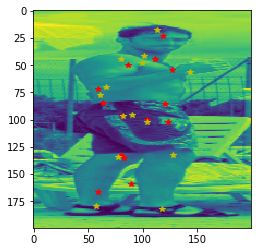

In [16]:
index = 7
model.eval()

current_imgs = test

imgs = next(iter(current_imgs))[0].cuda()
labels = next(iter(current_imgs))[1].cuda()[index].data.cpu().view(14, 2).numpy()

prediction = model(imgs)[index].data.cpu().view(14, 2).numpy()

fig, ax = plt.subplots()

ax.imshow(next(iter(current_imgs))[0][index, 0])
for point in prediction:
    ax.plot(point[0], point[1], 'r*')

for point in labels:
    ax.plot(point[0], point[1], 'y*')


In [17]:
index_num = 13

hog, blocks, global_mu = model.base(imgs)
print(hog.shape)

_, channel_num, _, _ = blocks.shape

block_shape = blocks[index_num, 0].shape

row_num, col_num = int(np.sqrt(blocks.shape[1])), int(np.sqrt(blocks.shape[1]))
fig2, ax2 = plt.subplots(row_num, col_num, figsize=(15, 15))

for x in range(row_num):
    for y in range(col_num):
        if row_num == 1 and col_num == 1:
            current_ax = ax2
        elif row_num == 1:
            current_ax = ax2[y]
        elif col_num == 1:
            current_ax = ax2[x]
        else:
            current_ax = ax2[x, y]

        mean2 = hog[index_num, x*col_num + y, :2]

        orientation2 = hog[index_num, x*col_num + y, 2:]
        current_ax.axis('off')
        arrow_scale = 1

        current_ax.imshow(blocks[index_num, x*col_num + y].data.cpu(), vmin=0, vmax=1)

        norm_value = torch.norm(orientation2)
        norm_value = min(norm_value.item(), 1)
        color_value = green_red_color_scale(norm_value)

        plot_arrow_img(current_ax, mean2, orientation2,  (block_shape[0] - 1, block_shape[1] - 1)
                       , arrow_scale=arrow_scale, alpha=0.7, color=color_value)

NameError: name 'imgs' is not defined

In [72]:
optimizer_function.zero_grad()
output = model(img.cuda())
loss = loss_function(output, label.cuda())
loss.backward()

for param in model.features.parameters():
    print(param.grad)

tensor([[[[  9609.0459,  10717.9990,   5915.6904],
          [  3691.0093,   8147.2256,   6994.3389],
          [ -2048.9653,  -3389.3870,   3758.3762]],

         [[ 10990.8916,  13162.8623,   9460.2939],
          [  6968.7979,  11831.7588,  11440.8789],
          [  2982.9180,   1562.8314,   8720.1357]],

         [[ 11924.3672,  13940.0566,  10550.7617],
          [  8368.4424,  14147.4600,  14695.1973],
          [  2059.6072,    878.0234,   8826.2715]]],


        [[[  6780.3560,   4239.5493,   -424.9608],
          [  3435.9185,   1428.5386,  -2548.1360],
          [  1668.6304,  -3539.7239,  -3159.0981]],

         [[ -7477.3569,  -8206.0498, -11160.0098],
          [ -7519.3325,  -7815.3174, -10164.6211],
          [ -5532.7764,  -9295.7471,  -7686.2993]],

         [[-10149.8701, -12362.8545, -15510.1885],
          [ -9452.0674, -10599.9727, -11954.1953],
          [ -6577.2129, -10407.4385,  -7258.7939]]],


        [[[ 19280.5898,  20637.7656,  22008.9023],
          [ 184

tensor(1.0002, device='cuda:0')
tensor(1.00000e-04 *
       -4.1981, device='cuda:0')
tensor(1.0002, device='cuda:0')
tensor(1.00000e-04 *
       -4.1981, device='cuda:0')
tensor(1.0002, device='cuda:0')
tensor(1.00000e-04 *
       -4.1981, device='cuda:0')


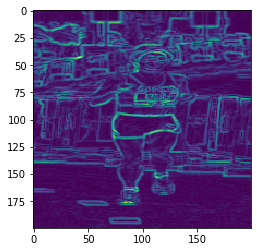

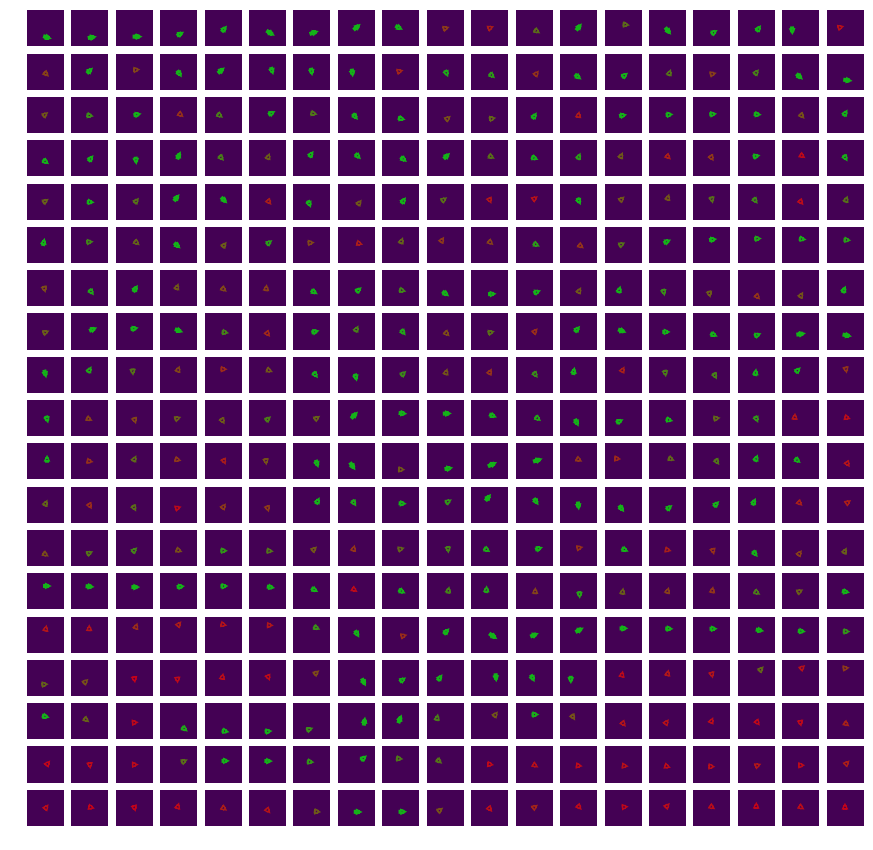

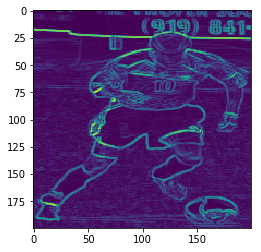

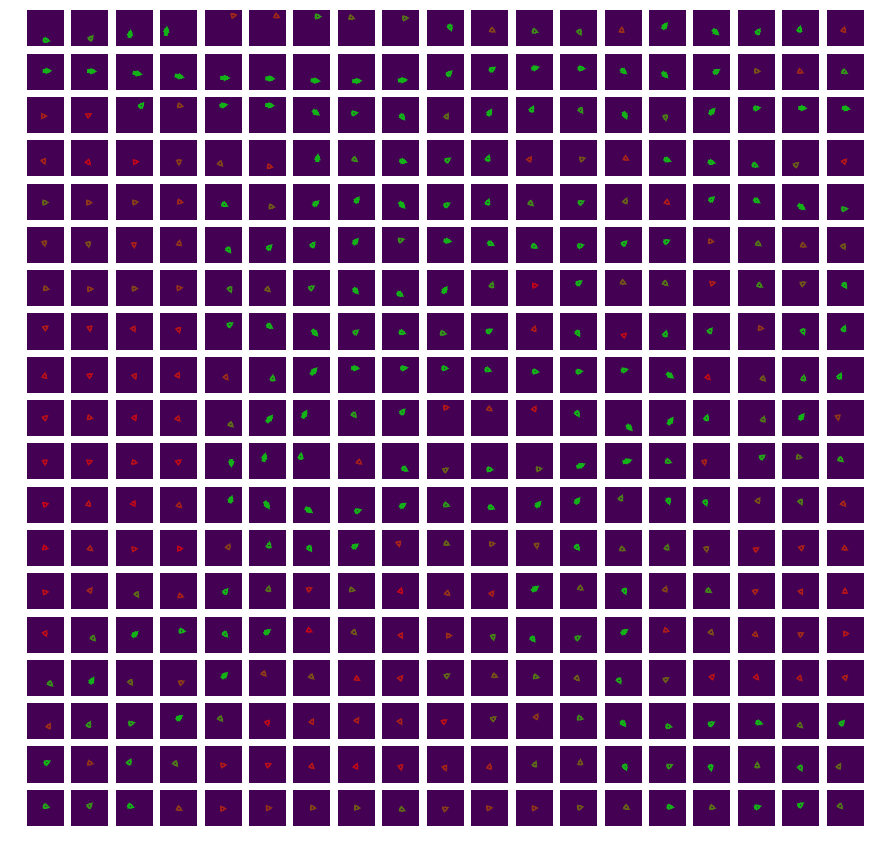

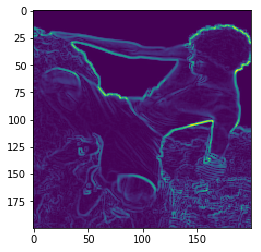

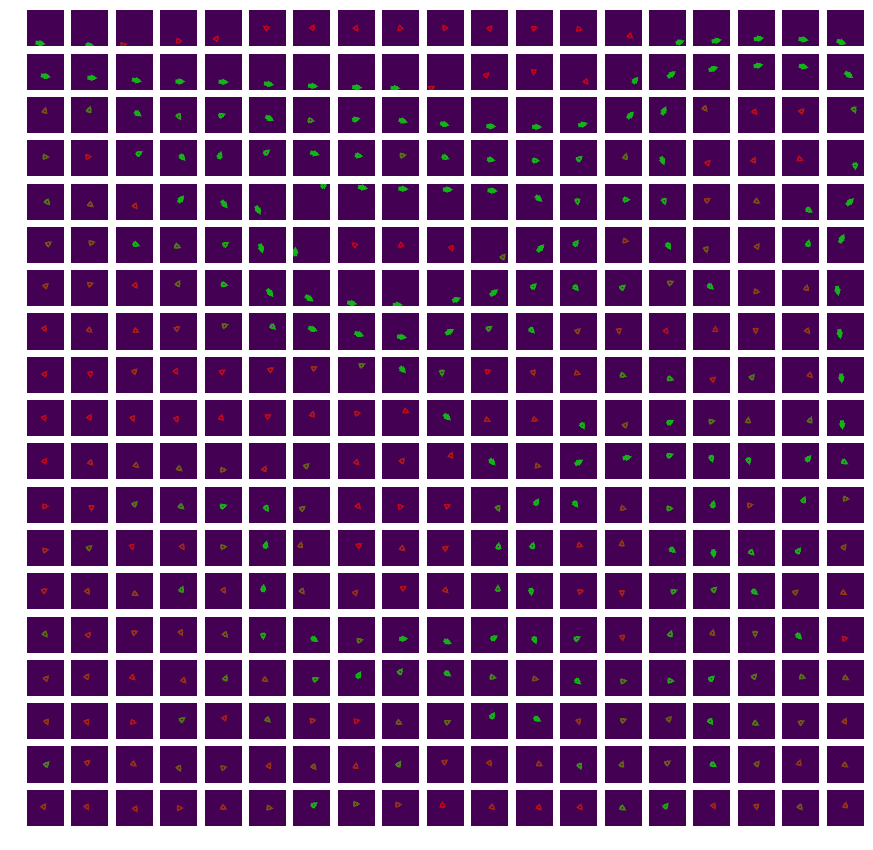

In [12]:
class SubNet(nn.Module):
    def __init__(self):
        super(SubNet, self).__init__()
    
    def forward(self, x):
        x = model.edge_detector(x)
        x = model.noise(x)
        hog, blocks, mu_global, U_global, theta = model.deep_hog(x)
        return x, hog, blocks
    
sub_net = SubNet()

activation, hog, blocks = sub_net(img.cuda())
activation = activation.data
hog = hog.data
blocks = blocks.data

for index_num in range(3):
    _, channel_num, _, _ = blocks.shape
    block_shape = blocks[index_num, 0].shape
    
    fig, ax = plt.subplots()
    ax.imshow(activation[index_num, 0])
    row_num, col_num = int(np.sqrt(blocks.shape[1])), int(np.sqrt(blocks.shape[1]))
    fig2, ax2 = plt.subplots(row_num, col_num, figsize=(15, 15))
    print(blocks.max())
    print(blocks.min())
    for x in range(row_num):
        for y in range(col_num):
            mean2 = hog[index_num, x*col_num + y, :2]

            orientation2 = hog[index_num, x*col_num + y, 2:]
            ax2[x, y].axis('off')
            arrow_scale = 0.2

            ax2[x, y].imshow(torch.zeros_like(blocks[index_num, x*col_num + y]), vmin=0, vmax=1)

            norm_value = torch.norm(orientation2)
            norm_value = min(norm_value.item() / 3, 1)
            color_value = green_red_color_scale(norm_value)
            plot_arrow_img(ax2[x, y], mean2, orientation2,  (block_shape[0] - 1, block_shape[1] - 1)
                           , arrow_scale=arrow_scale, alpha=0.7, color=color_value)

